# Downloading market data examples

Saeed Amen - saeed@cuemacro.com

Getting market data using findatapy for a number of different data sources. findatapy is used extensively in finmarketpy. The idea is that we use a common API for all these different data sources, which makes it easier to combine them together in our analysis. Here we'll show some examples of downloading data from `quandl` and `bloomberg`.

findatapy also has ticker mapping functionality that allows you to use your own nicknames for tickers, rather than the vendor tickers. There are lots of in built ticker mappings already (defined in CSV files which you can edit in the config folder). Later we show, how to download our predefined ticker mappings and also how to query them, to extract the original vendor tickers. Most of the predefined tickers involve FX markets, given the focus of Cuemacro.

Let's first do some imports for objects we'll use later from `chartpy`, `findatapy` and `finmarketpy`. We'll also disable the log output.

In [1]:
import datetime

from chartpy import Chart, Style
from findatapy.market import Market, MarketDataGenerator, MarketDataRequest

# So we don't see deprecated warnings... when you're coding it's usually good to leave these!
import warnings
warnings.filterwarnings('ignore')

# Disable logging messages, to make output tidier
import logging
import sys

logging.disable(sys.maxsize)

Set the engine to output the chart. One of the engines we can use is `matplotlib` and `plotly` is also supported. Create the `Market` object for fetching data in conjunction with `MarketDataRequest` objects.

In [2]:
chart = Chart(engine='matplotlib')
market = Market(market_data_generator=MarketDataGenerator())

## What is the MarketDataRequest?

`MarketDataRequest` is used to request market data from a data vendor/external source. Below we mention some of the properties.

`freq` represents the frequency of the data we want to download. Note that not every data vendor will provide high frequency data for every ticker.

* `daily` - daily data (default)
* `tick` - tick data (eg. `dukascopy`, `fxcm`, `bloomberg`, `eikon`)
* `intraday` - minute data (eg. `bloomberg`, `eikon`)

findatapy supports many different `data_source` from a number of different vendors (both traditional market data and cryptocurrencies). Here we write a selection. We are continually adding more sources. If you'd like to sponsor the addition of a new data source let us know!

* `bloomberg` - Bloomberg terminal/blpapi (paid) 
* `eikon` - Refinitiv Eikon (paid)
* `quandl` - Quandl data (paid)
* `dukascopy` - retail FX tick data (free) 
* `fxcm` - retail FX tick data (free)
* `alfred` - ALFRED/FRED mostly economic data (free)
* `yahoo` - equities data (free)
* `bitcoincharts`, `poloniex`, `binance`, `bitfinex`, `gdax`, `kraken`, `bitmex`, `alphavantage`, `huobi` - crypto data

Or  we can give `MarketDataRequest` a `csv` or `parquet` file as a source

* `tickers`: (can be list) eg. `EURUSD` - our nickname for tickers to use internally in findatapy
* `vendor_tickers`: (can be list) eg. `EURUSD Curncy` - the particular vendor ticker to use for that same asset
* `fields`: (can be list) eg. `close` - our nickname for the field
* `vendor_fields`: (can be list) eg. `PX_LAST` - the particular vendor field
* `cache_algo` (eg. internet, memory) eg. `internet_load_return` - internet will forcibly download from the internet
* `quandl_api_key`: insert API key from Quandl

## Downloading from Quandl example

In the below example, we download the monthly average interest rate for UK resident monetary financial institutions, using Quandl.

In [3]:
try:
    import os
    QUANDL_API_KEY = os.environ['QUANDL_API_KEY']
except:
    QUANDL_API_KEY = 'TYPE_YOUR_KEY_HERE'

# Monthly average of UK resident monetary financial institutions' (excl. Central Bank) sterling
# Weighted average interest rate, other loans, new advances, on a fixed rate to private non-financial corporations (in percent)
# not seasonally adjusted
md_request = MarketDataRequest(
    start_date="01 Jan 2005",  # start date
    data_source='quandl',      # use Quandl as data source
    tickers=['Weighted interest rate'],
    fields=['close'],         # which fields to download
    vendor_tickers=['BOE/CFMBJ84'],  # ticker (Bloomberg)
    vendor_fields=['close'],  # which Bloomberg fields to download
    cache_algo='internet_load_return',
    quandl_api_key=QUANDL_API_KEY)  # how to return data

We've defined the `MarketDataRequest` and now we can download it.

In [4]:
df = market.fetch_market(md_request)

Set style for graph, axis labels and plot. Creates an object with essentially the same characteristics as a matplotlib graph.

In [5]:
style = Style()

style.title = 'BoE weighted interest rate'
style.scale_factor = 3
style.file_output = "boe-rate.png"
style.source = 'Quandl/BoE'

Now plot it!

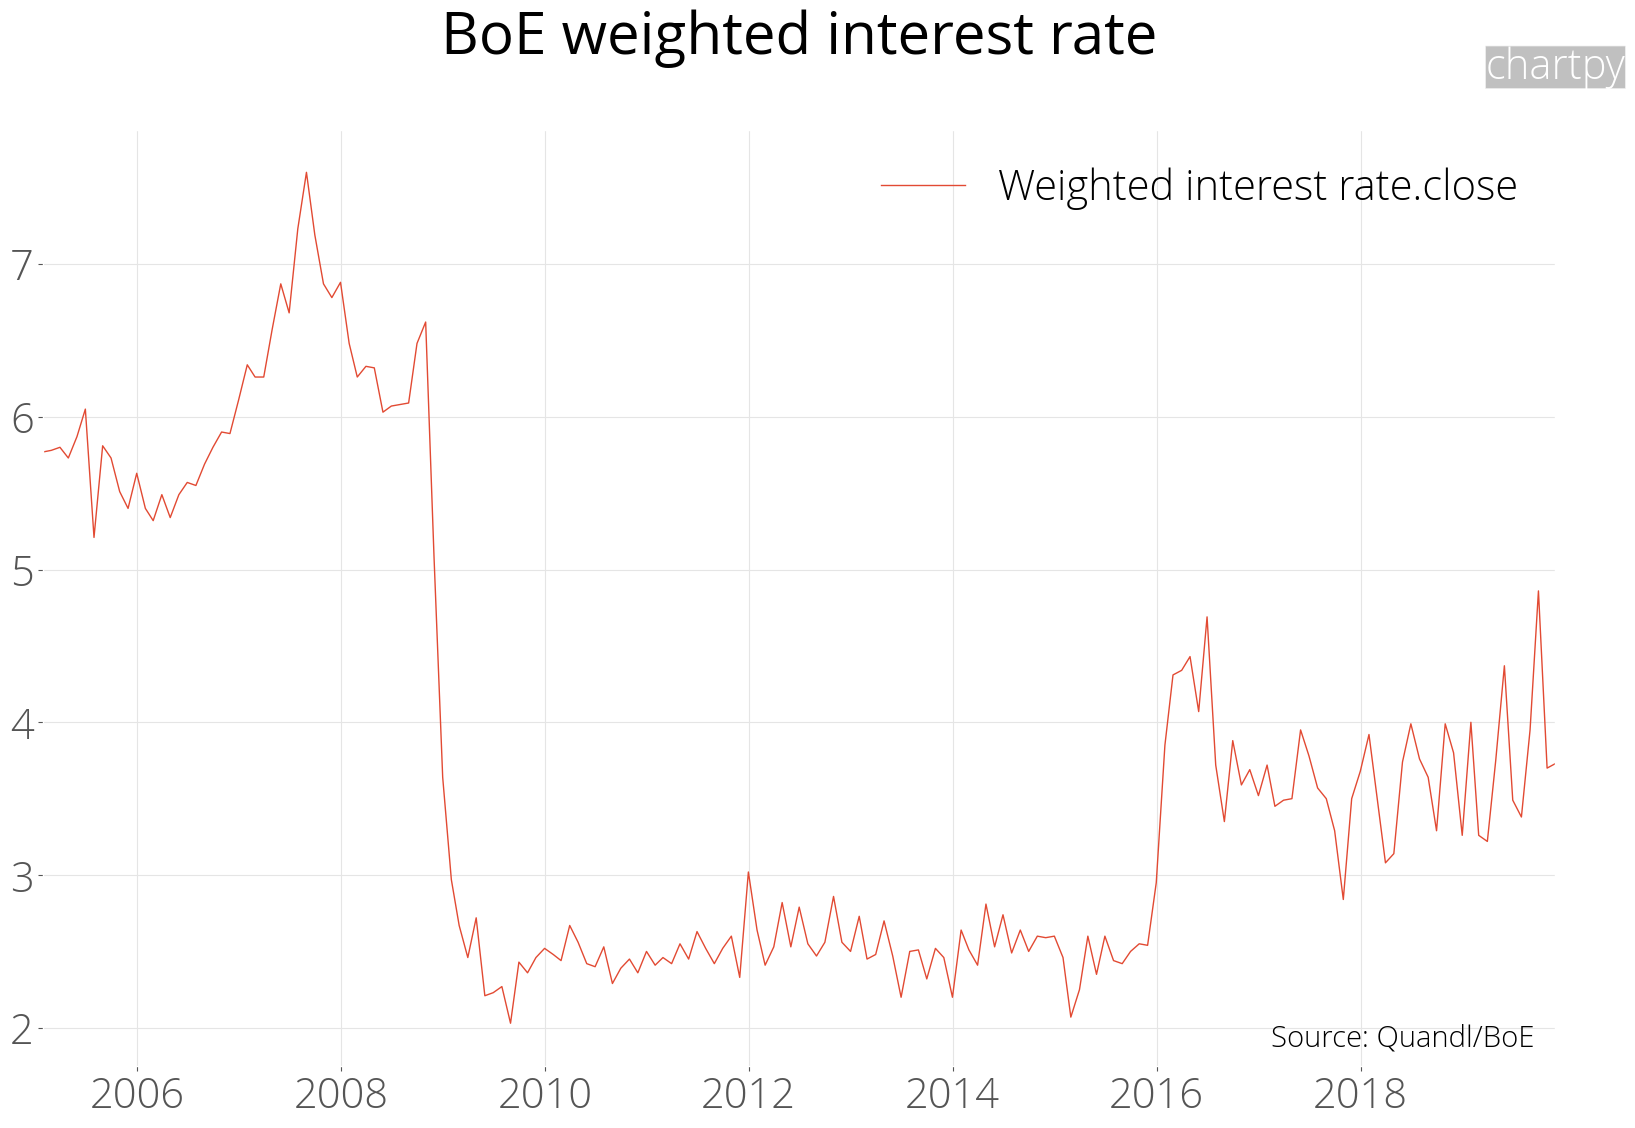

In [6]:
chart.plot(df, style=style)

# Using strings to make data requests

We noted that we have predefined tickers already in our ticker mapping framework. We also showed how to use `MarketDataRequest` to download market data, whether it is predefined or not. Here we are downloading EURUSD data from Bloomberg with NY close, but rather than using a `MarketDataRequest` we just use a single string, which obviously has a lot less boilerplate code. By default it will select one week. Note for this section to work, you will need to run this on a machine with `blpapi` installed, and a Bloomberg Terminal subscription on there.

In [11]:
df = market.fetch_market("fx.bloomberg.daily.NYC.EURUSD.close")
print(df)

            EURUSD.close
Date                    
2021-01-27        1.2111
2021-01-28        1.2122
2021-01-29        1.2136
2021-02-01        1.2060
2021-02-02        1.2044
...                  ...
2022-01-20        1.1312
2022-01-21        1.1344
2022-01-24        1.1326
2022-01-25        1.1301
2022-01-26        1.1285

[261 rows x 1 columns]


Let's download intraday EURUSD data in the same way, which is a predefined ticker (underneath this will map to `vendor_tickers` for Bloomberg `EURUSD CMPN Curncy`.

In [8]:
df = market.fetch_market("fx.bloomberg.intraday.NYC.EURUSD.close", start_date='week')
print(df)

                           EURUSD.close
Date                                   
2022-01-19 15:57:00+00:00        1.1344
2022-01-19 15:58:00+00:00        1.1345
2022-01-19 15:59:00+00:00        1.1345
2022-01-19 16:00:00+00:00        1.1347
2022-01-19 16:01:00+00:00        1.1345
...                                 ...
2022-01-26 15:52:00+00:00        1.1282
2022-01-26 15:53:00+00:00        1.1281
2022-01-26 15:54:00+00:00        1.1281
2022-01-26 15:55:00+00:00        1.1281
2022-01-26 15:56:00+00:00        1.1282

[7200 rows x 1 columns]


We can download arbitrary tickers, which are not predefined too in our CSV files, using the `raw` keyword, and select whatever tickers we want. We haven't specified all the parameters like `freq` or `fields`, in which case the defaults we use. Here it would be `daily` and `close` on Bloomberg which corresponds to `PX_LAST`.

In [9]:
df = market.fetch_market("raw.data_source.bloomberg.tickers.VIX.vendor_tickers.VIX Index", start_date='week')

print(df)

            VIX.close
Date                 
2022-01-20  25.590000
2022-01-21  28.850000
2022-01-24  29.900000
2022-01-25  31.160000
2022-01-26  29.700001


# Querying for predefined tickers

We can also download all the tickers in our predefined tickers list (which are defined in our CSV files), which has this format, and will likely contain many tickers.

`category.data_source.freq.cut`

We can also specify individual predefined tickers and fields as follows:

`category.data_source.freq.cut.tickers.fields`

Let's get all the predefined tickers/categories, which are from `quandl` and a few from `bloomberg`.

In [3]:
from findatapy.util import ConfigManager
cm = ConfigManager().get_instance()

# Get all the categories for raw data (note this won't include generated categories like fx-vol-market,
# which aggregate from many other categories)
categories = list(cm.get_categories_from_tickers())

# Filter those categories which include quandl
quandl_category = [x for x in categories if 'quandl' in x]
print(quandl_category)

# Filter those categories which include bloomberg and print the first few
bloomberg_category = [x for x in categories if 'bloomberg' in x][0:10]
print(bloomberg_category)

['fx.quandl.daily.NYC', 'fx-spot-volume.quandl.daily.LOC']
['fx.bloomberg.daily.BGN', 'fx.bloomberg.daily.BSTP', 'fx.bloomberg.daily.NYC', 'fx.bloomberg.daily.TOK', 'fx.bloomberg.daily.LDN', 'fx.bloomberg.daily.10AM', 'fx-tot.bloomberg.daily.NYC', 'fx-tot-forwards.bloomberg.daily.NYC', 'fx.bloomberg.intraday.NYC', 'fx.bloomberg.intraday.BGNE']


Let's download all the tickers in the category/data_source/freq/cut for `fx.quandl.daily.NYC`.

In [11]:
try:
    import os
    QUANDL_API_KEY = os.environ['QUANDL_API_KEY']
except:
    QUANDL_API_KEY = 'TYPE_YOUR_KEY_HERE'

df = market.fetch_market(md_request_str="fx.quandl.daily.NYC", start_date='year',
                         md_request=MarketDataRequest(quandl_api_key=QUANDL_API_KEY))
print(df.head(5))

            EURUSD.close  GBPUSD.close  AUDUSD.close  NZDUSD.close  \
Date                                                                 
2020-05-05        1.0844        1.2449        0.6458        0.6065   
2020-05-06        1.0806        1.2347        0.6414        0.6019   
2020-05-07        1.0815        1.2349        0.6500        0.6086   
2020-05-08        1.0854        1.2436        0.6543        0.6147   
2020-05-11        1.0818        1.2330        0.6472        0.6065   

            USDCAD.close  USDCHF.close  USDNOK.close  USDSEK.close  \
Date                                                                 
2020-05-05        1.4025        0.9721       10.2603        9.8296   
2020-05-06        1.4143        0.9745       10.2799        9.8486   
2020-05-07        1.3972        0.9746       10.2274        9.8128   
2020-05-08        1.3910        0.9699       10.1864        9.7590   
2020-05-11        1.4024        0.9722       10.2850        9.8649   

            USDJPY

We can also query this category combination too for all available tickers/fields/vendor tickers.

In [17]:
# For this category, get all the tickers, vendor_tickers and fields which are available
tickers = cm.get_tickers_list_for_category_str(categories[0])
fields = cm.get_fields_list_for_category_str(categories[0])
vendor_tickers = cm.get_vendor_tickers_list_for_category_str("fx.quandl.daily.NYC")

# We don't need to add the environment (eg. backtest)
print("For category " + quandl_category[0])
print("tickers = " + str(tickers))
print("vendor_tickers = " + str(vendor_tickers))
print("fields = " + str(fields))

For category fx.quandl.daily.NYC
tickers = ['EURUSD', 'GBPUSD', 'AUDUSD', 'NZDUSD', 'USDCAD', 'USDCHF', 'USDNOK', 'USDSEK', 'USDJPY']
vendor_tickers = ['FRED/DEXUSEU', 'FRED/DEXUSUK', 'FRED/DEXUSAL', 'FRED/DEXUSNZ', 'FRED/DEXCAUS', 'FRED/DEXSZUS', 'FRED/DEXNOUS', 'FRED/DEXSDUS', 'FRED/DEXJPUS']
fields = ['close']


Let's download EURUSD from Quandl, using our predefined mapping.

In [13]:
df = market.fetch_market(md_request_str="fx.quandl.daily.NYC.EURUSD", start_date='year',
                         md_request=MarketDataRequest(quandl_api_key=QUANDL_API_KEY))
print(df.head(5))

            EURUSD.close
Date                    
2020-05-05        1.0844
2020-05-06        1.0806
2020-05-07        1.0815
2020-05-08        1.0854
2020-05-11        1.0818


We can extract the `vendor_tickers` for our predefined ticker, not just for large categories.

In [18]:
vendor_tickers = cm.convert_library_to_vendor_ticker_str("fx.quandl.daily.NYC.EURUSD")

print(vendor_tickers)

FRED/DEXUSEU


We can convert from our predefined fields to the vendor field. Here we show that our `close` field for `bloomberg` is `PX_LAST` on Bloomberg.

In [21]:
vendor_fields = cm.convert_library_to_vendor_field('bloomberg', 'close')
print(vendor_fields)

PX_LAST
